# Heart Disease Prediction - Classification Project

## Project Overview
Binary classification to predict presence of heart disease/stroke (0/1) using clinical and demographic features from Heart Disease dataset.

## Dataset
- Location: `dataset/heart_disease.csv`
- Target: `Heart_ stroke` column (values: "No"/"yes" - will be converted to binary: 0 = no disease, 1 = disease present)
- Size: 4,238 samples with 15 features

## 1. Setup and Imports
**Task:** Import all necessary libraries and set up project paths and directories

In [89]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, classification_report, roc_auc_score, 
                            roc_curve, precision_recall_curve)

# Model persistence
import joblib

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Configuration
DATA_PATH = Path(r'C:\Users\salla\OneDrive\Desktop\ML Project\dataset\heart_disease.csv')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
(OUTPUT_DIR / 'figures').mkdir(exist_ok=True, parents=True)
(OUTPUT_DIR / 'models').mkdir(exist_ok=True, parents=True)

print("Setup complete!")

Setup complete!


## 2. Load and Inspect Data
**Task:** Load the dataset and perform initial inspection to understand its structure

In [90]:
# Load dataset
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

# Read CSV and convert "NA" strings to actual NaN values for proper imputation
df = pd.read_csv(DATA_PATH, na_values=['NA', 'na', 'N/A', 'n/a', ''])
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\n" + "="*50)
print("First 5 rows:")
print("="*50)
df.head()

Dataset shape: (4238, 16)

Columns: ['Gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'Heart_ stroke']

First 5 rows:


,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_ stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No


## 3. Data Quality Assessment
**Task:** Check for missing values, data types, and basic statistics

In [91]:
# Data types and basic info
print("Dataset Info:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Missing Values:")
print("="*50)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values found!")

print("\n" + "="*50)
print("Basic Statistics:")
print("="*50)
df.describe()

Dataset Info:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   object 
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   object 
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Heart_ stroke    4238 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 529.9+ KB



,age,currentSmoker,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,4238.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000
mean,49.584946,0.494101,9.003089,0.029630,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753
std,8.572160,0.500024,11.920094,0.169584,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998
min,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000
50%,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000
75%,56.000000,1.000000,20.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000
max,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000


## 4. Target Variable Analysis
**Task:** Analyze the target variable distribution and convert to binary classification

Target variable distribution:
Heart_ stroke
No     3594
yes     644
Name: count, dtype: int64

Unique values: ['No' 'yes']

Binary target distribution:
target
0    3594
1     644
Name: count, dtype: int64

Class balance: target
0    0.848042
1    0.151958
Name: proportion, dtype: float64


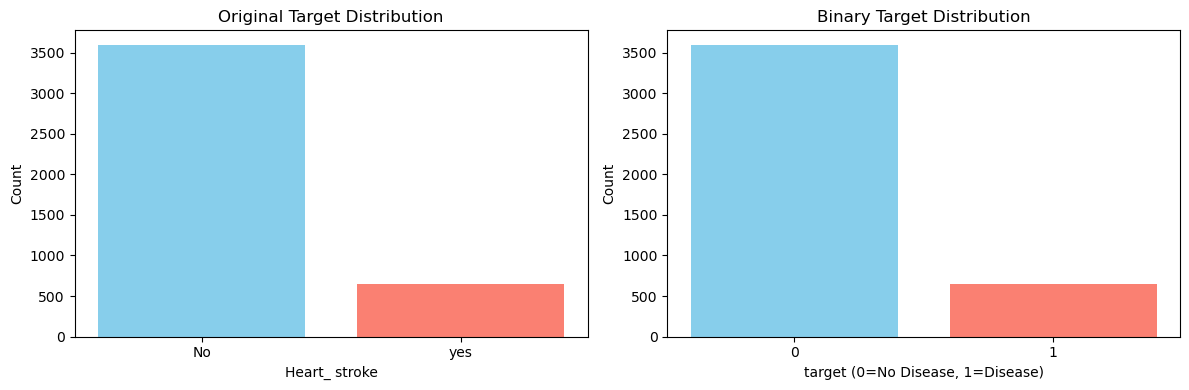

In [92]:
# Check target variable distribution
target_col = 'Heart_ stroke'  # Note: column name has space/underscore
print("Target variable distribution:")
print("="*50)
print(df[target_col].value_counts())
print(f"\nUnique values: {df[target_col].unique()}")

# Convert to binary: "No" = 0, "yes" = 1
df['target'] = (df[target_col].str.lower() == 'yes').astype(int)
print(f"\nBinary target distribution:")
print(df['target'].value_counts().sort_index())
print(f"\nClass balance: {df['target'].value_counts(normalize=True)}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original target
axes[0].bar(df[target_col].value_counts().index, df[target_col].value_counts().values, color=['skyblue', 'salmon'])
axes[0].set_title('Original Target Distribution')
axes[0].set_xlabel('Heart_ stroke')
axes[0].set_ylabel('Count')

# Binary target
axes[1].bar(df['target'].value_counts().index, df['target'].value_counts().values, color=['skyblue', 'salmon'])
axes[1].set_title('Binary Target Distribution')
axes[1].set_xlabel('target (0=No Disease, 1=Disease)')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Exploratory Data Analysis (EDA)
**Task:** Explore relationships between features and target, identify patterns and correlations

Numeric features: ['age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

Categorical features: ['Gender', 'education', 'prevalentStroke']


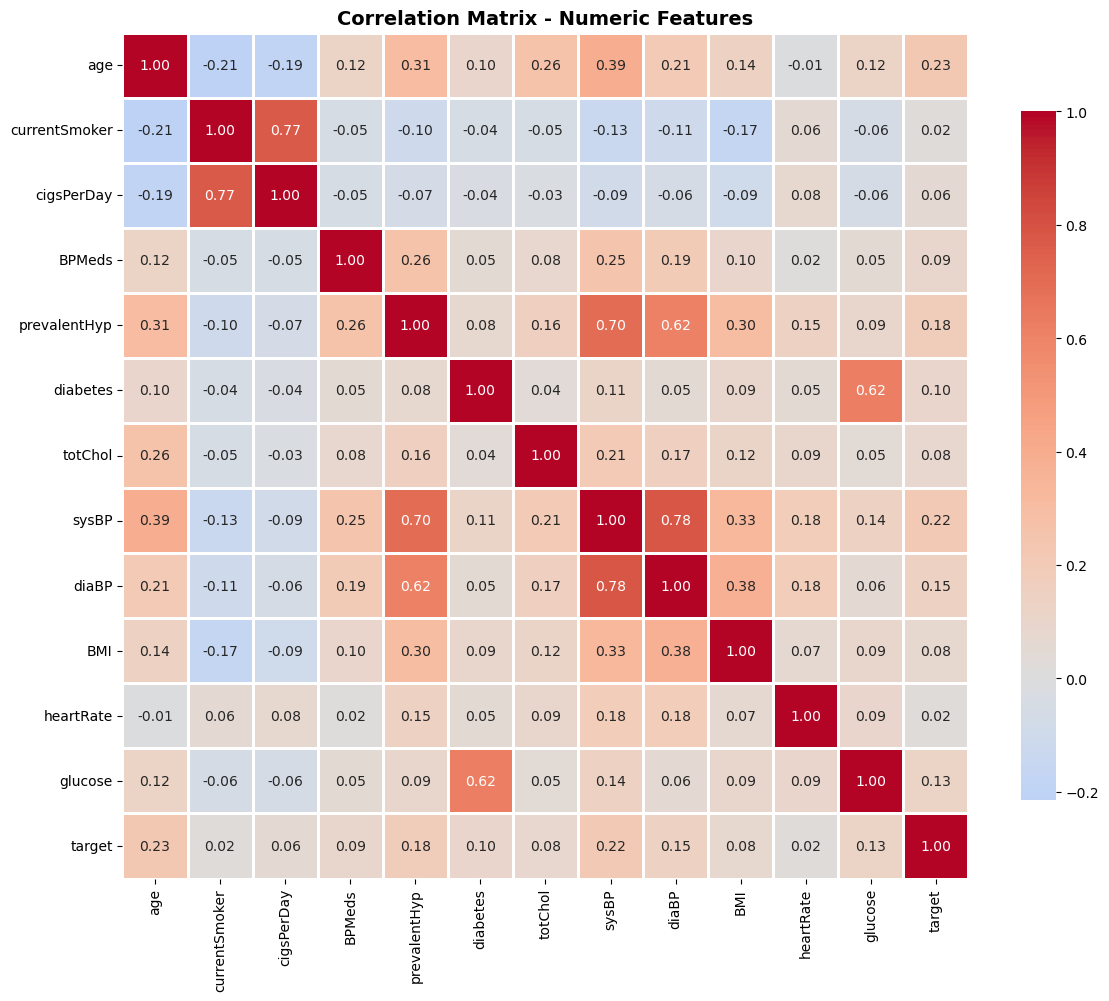


Feature Correlations with Target:
age              0.225256
sysBP            0.216429
prevalentHyp     0.177603
diaBP            0.145299
glucose          0.125544
diabetes         0.097317
BPMeds           0.087489
totChol          0.082184
BMI              0.075192
cigsPerDay       0.057884
heartRate        0.022913
currentSmoker    0.019456
Name: target, dtype: float64


In [93]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove non-feature columns (target and Heart_ stroke are labels, not features)
numeric_cols = [c for c in numeric_cols if c not in ['target']]
categorical_cols = [c for c in categorical_cols if c not in ['Heart_ stroke']]

print(f"Numeric features: {numeric_cols}")
print(f"\nCategorical features: {categorical_cols}")

# Correlation matrix for numeric features only (categorical need encoding first)
# Make sure target exists before adding to correlation
if 'target' in df.columns:
    corr_matrix = df[numeric_cols + ['target']].corr()
else:
    print("Warning: 'target' column not found, creating correlation matrix without it")
    corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlations with target
print("\n" + "="*50)
print("Feature Correlations with Target:")
print("="*50)
target_corr = corr_matrix['target'].sort_values(ascending=False)
target_corr = target_corr[target_corr.index != 'target']
print(target_corr)

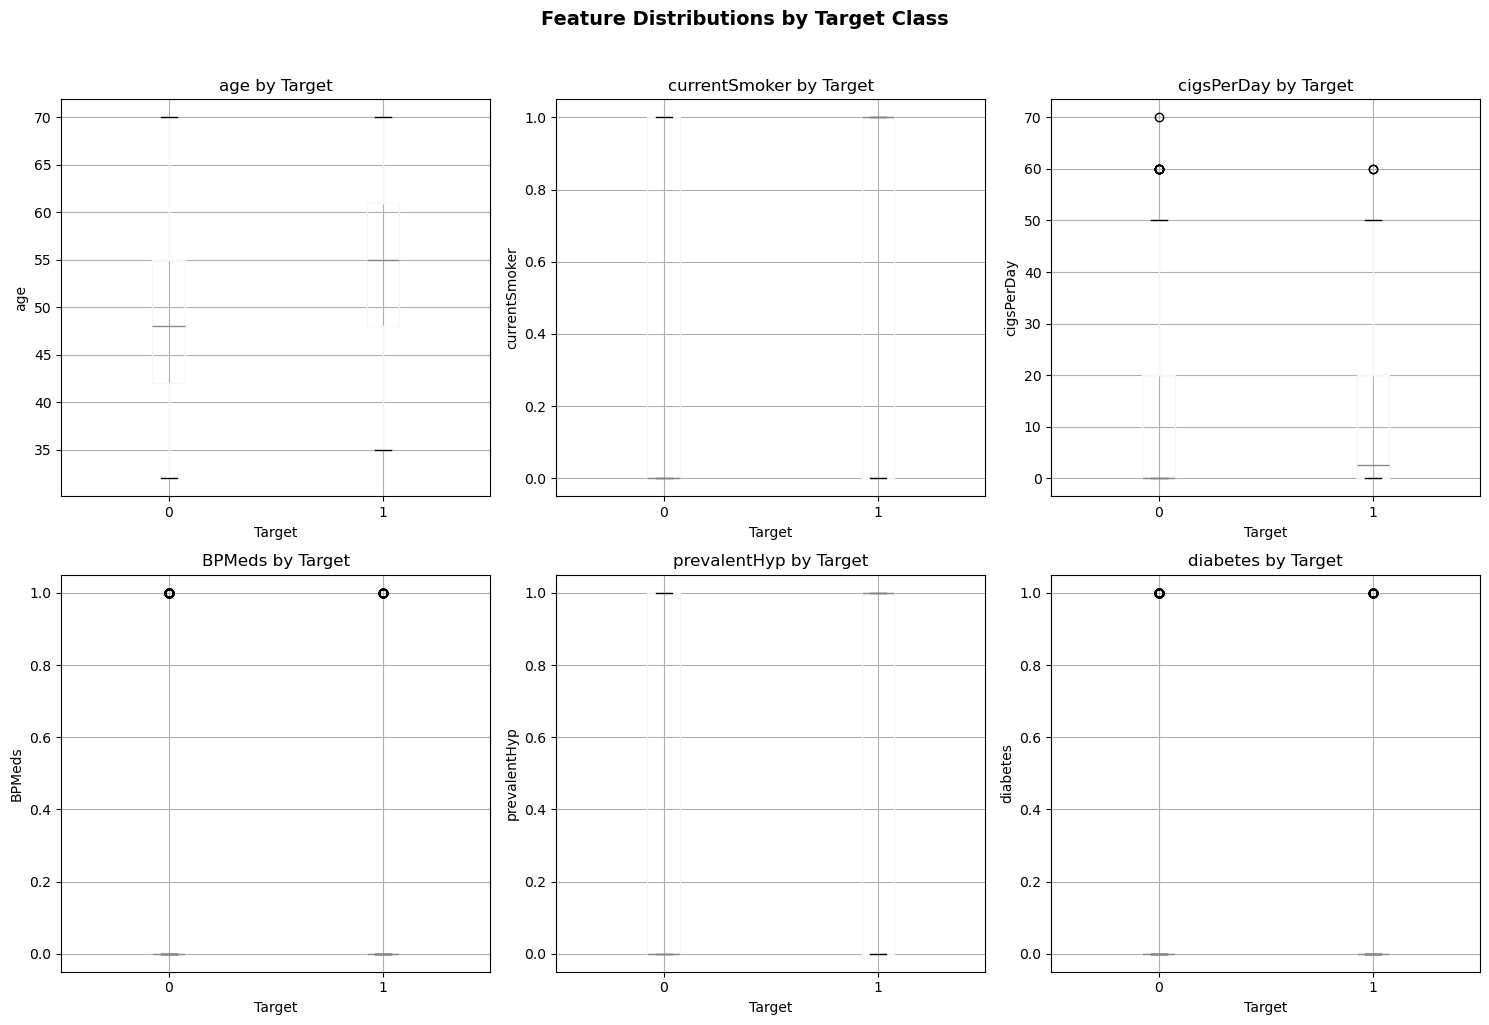

In [94]:
# Distribution plots for key numeric features
# Select key numeric features from the new dataset
numeric_cols_available = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_available = [c for c in numeric_cols_available if c not in ['target']]
key_features = numeric_cols_available[:6]  # Select first 6 numeric features for visualization

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        ax = axes[idx]
        df.boxplot(column=feature, by='target', ax=ax)
        ax.set_title(f'{feature} by Target')
        ax.set_xlabel('Target')
        ax.set_ylabel(feature)
        plt.setp(ax.get_xticklabels(), rotation=0)

# Remove extra subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Feature Distributions by Target Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Data Preprocessing
**Task:** Prepare features for machine learning - handle missing values, encode categorical variables, remove duplicates, and split data

**Note:** The dataset (`heart_disease.csv`) requires preprocessing:
- ⚠️ **Missing Values**: Present in several columns (education, cigsPerDay, BPMeds, totChol, BMI, heartRate, glucose)
- ⚠️ **Categorical Variables**: Need encoding (Gender, education, prevalentStroke)
- ⚠️ **Duplicate Removal**: Check for and remove duplicate rows to prevent data leakage

**Preprocessing steps:**
1. **Remove duplicate rows** to prevent data leakage
2. **Handle missing values** using imputation
3. **Encode categorical variables** (Gender, education, prevalentStroke)
4. Split the data into training and test sets
5. Apply feature scaling (StandardScaler) for better model performance

In [95]:
# Prepare features and target
# Exclude target column and the original Heart_ stroke column
FEATURES = [c for c in df.columns if c not in ['target', 'Heart_ stroke']]
TARGET = 'target'

# IMPORTANT: Remove duplicate rows to prevent data leakage
# Duplicate rows in train/test split can cause artificially perfect scores
print("Checking for duplicate rows...")
duplicates_before = len(df)
df = df.drop_duplicates()
duplicates_removed = duplicates_before - len(df)
if duplicates_removed > 0:
    print(f"⚠️  Removed {duplicates_removed} duplicate rows ({duplicates_removed/duplicates_before*100:.1f}% of data)")
    print(f"   Remaining rows: {len(df)}")
else:
    print("✓ No duplicate rows found")

X = df[FEATURES].copy()
y = df[TARGET].astype(int)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {FEATURES}")

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Check unique values in categorical features
print("\n" + "="*50)
print("Categorical Feature Value Counts:")
print("="*50)
for col in categorical_features:
    print(f"\n{col}:")
    print(X[col].value_counts())

# Check missing values
print("\n" + "="*50)
print("Missing Values in Features:")
print("="*50)
missing = X.isnull().sum()
missing_pct = (missing / len(X)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values found!")

Checking for duplicate rows...
✓ No duplicate rows found

Features shape: (4238, 15)
Target shape: (4238,)

Feature columns: ['Gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

Numeric features (12): ['age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
Categorical features (3): ['Gender', 'education', 'prevalentStroke']

Categorical Feature Value Counts:

Gender:
Gender
Female    2419
Male      1819
Name: count, dtype: int64

education:
education
uneducated       1720
primaryschool    1253
graduate          687
postgraduate      473
Name: count, dtype: int64

prevalentStroke:
prevalentStroke
no     4213
yes      25
Name: count, dtype: int64

Missing Values in Features:
            Missing Count  Percentage
glucose               388    9.155262
education             105    2.477

In [96]:
# Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining target distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest target distribution:\n{y_test.value_counts().sort_index()}")

Training set: 3390 samples
Test set: 848 samples

Training target distribution:
target
0    2875
1     515
Name: count, dtype: int64

Test target distribution:
target
0    719
1    129
Name: count, dtype: int64


## 7. Build Preprocessing Pipeline
**Task:** Create preprocessing pipelines for numeric and categorical features

**Preprocessing steps:**
- **Numeric features**: Impute missing values with median, then scale using StandardScaler
- **Categorical features**: Impute missing values with most frequent, then one-hot encode
- This handles the mixed data types and missing values in the dataset

In [97]:
# Create preprocessing pipelines
# Numeric pipeline: impute missing values with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline created!")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Numeric preprocessing: Median imputation + StandardScaler")
print(f"  - Categorical preprocessing: Most frequent imputation + OneHotEncoder")

Preprocessing pipeline created!
  - Numeric features: 12
  - Categorical features: 3
  - Numeric preprocessing: Median imputation + StandardScaler
  - Categorical preprocessing: Most frequent imputation + OneHotEncoder


## 8. Baseline Model - Logistic Regression
**Task:** Train and evaluate a baseline logistic regression model

Training Logistic Regression model...

Logistic Regression - Evaluation Metrics:
Accuracy:  0.8420
Precision: 0.3684
Recall:    0.0543
F1-Score:  0.0946
ROC-AUC:   0.6953

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.98      0.91       719
     Disease       0.37      0.05      0.09       129

    accuracy                           0.84       848
   macro avg       0.61      0.52      0.50       848
weighted avg       0.78      0.84      0.79       848



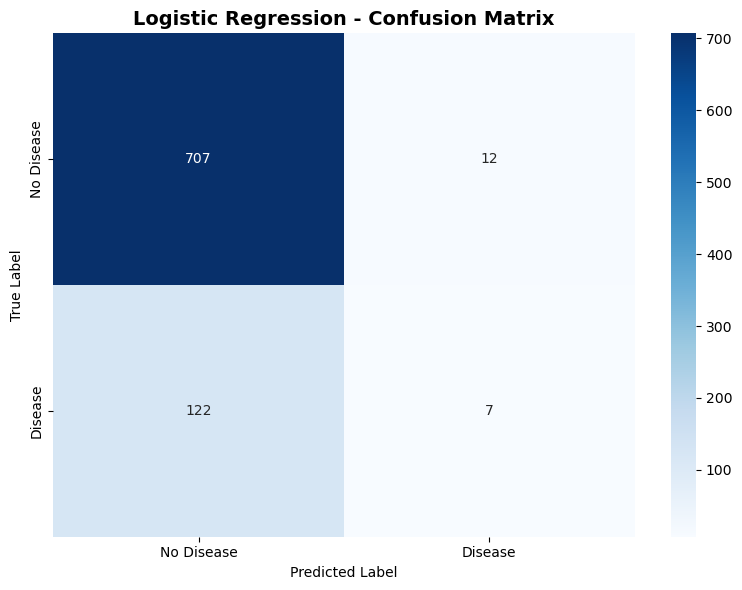


Model saved!


In [98]:
# Build baseline model pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("\n" + "="*50)
print("Logistic Regression - Evaluation Metrics:")
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_lr, target_names=['No Disease', 'Disease']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'cm_logistic_regression.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
joblib.dump(lr_pipeline, OUTPUT_DIR / 'models' / 'baseline_logistic_regression.joblib')
print("\nModel saved!")

## 9. Random Forest Classifier
**Task:** Train and evaluate a Random Forest model for comparison

Training Random Forest model...

Random Forest - Evaluation Metrics:
Accuracy:  0.8455
Precision: 0.4167
Recall:    0.0388
F1-Score:  0.0709
ROC-AUC:   0.6295

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.99      0.92       719
     Disease       0.42      0.04      0.07       129

    accuracy                           0.85       848
   macro avg       0.63      0.51      0.49       848
weighted avg       0.79      0.85      0.79       848



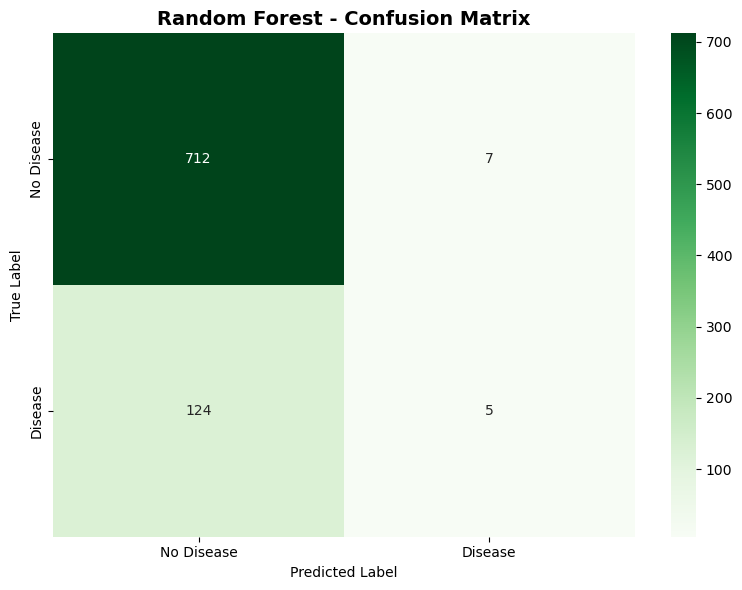


Model saved!


In [99]:
# Build Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train the model
print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("\n" + "="*50)
print("Random Forest - Evaluation Metrics:")
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=['No Disease', 'Disease']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'cm_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
joblib.dump(rf_pipeline, OUTPUT_DIR / 'models' / 'random_forest.joblib')
print("\nModel saved!")

## 10. Model Comparison and ROC Curves
**Task:** Compare model performance and visualize ROC curves

In [100]:
# Compare models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_rf)],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_proba_lr), roc_auc_score(y_test, y_pred_proba_rf)]
})

print("\n" + "="*50)
print("Model Comparison:")
print("="*50)
print(models_comparison.round(4))

# Save comparison table
models_comparison.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print("\nComparison table saved!")


Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.8420     0.3684  0.0543    0.0946   0.6953
1        Random Forest    0.8455     0.4167  0.0388    0.0709   0.6295

Comparison table saved!


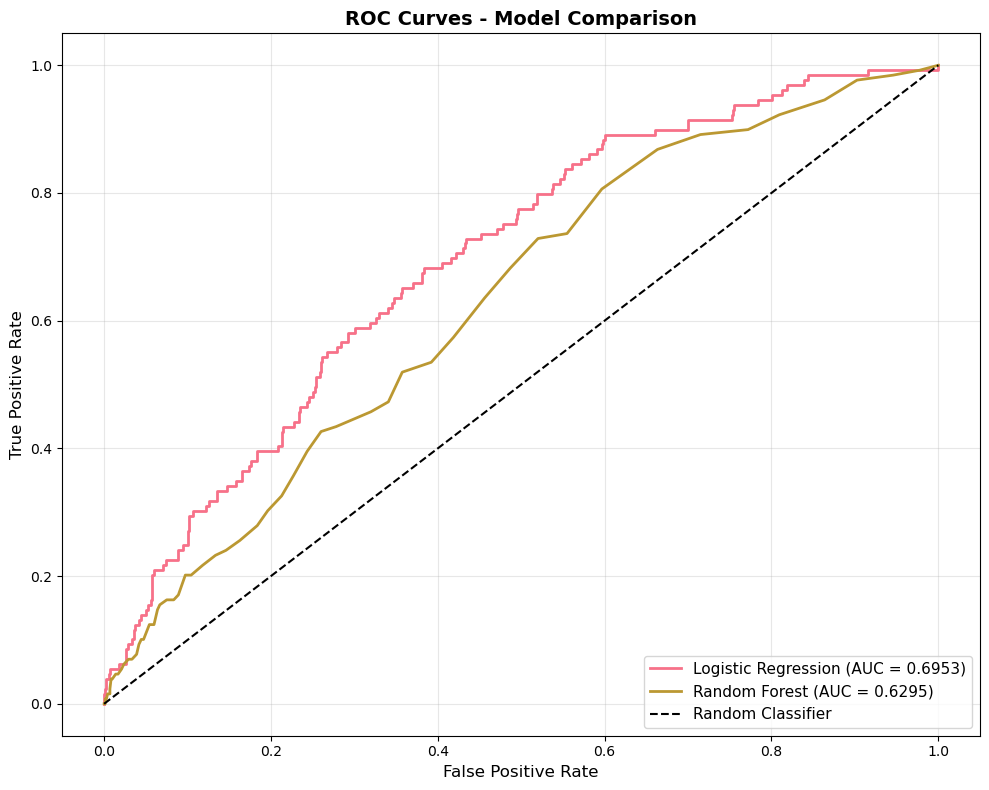

In [101]:
# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Feature Importance Analysis
**Task:** Analyze and visualize feature importance from Random Forest model

In [102]:
# Get feature names after preprocessing
# Since all features are already numeric and we only use StandardScaler,
# feature names remain the same
preprocessor.fit(X_train)
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

# Get feature importance from Random Forest
rf_importance = rf_pipeline.named_steps['classifier'].feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

print("\n" + "="*50)
print("Top 15 Most Important Features:")
print("="*50)
print(feature_importance_df.head(15))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
feature_importance_df.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)
print("\nFeature importance saved!")

NameError: name 'feature_names' is not defined

## 12. Cross-Validation Evaluation
**Task:** Perform cross-validation to get more robust performance estimates


Cross-Validation Results (ROC-AUC):

Logistic Regression:
  Mean: 0.9157
  Std:  0.0146
  Scores: [0.9202381  0.9264881  0.89032738 0.93139881 0.9099032 ]

Random Forest:
  Mean: 0.9984
  Std:  0.0019
  Scores: [0.99479167 1.         0.99880952 0.99821429 1.        ]


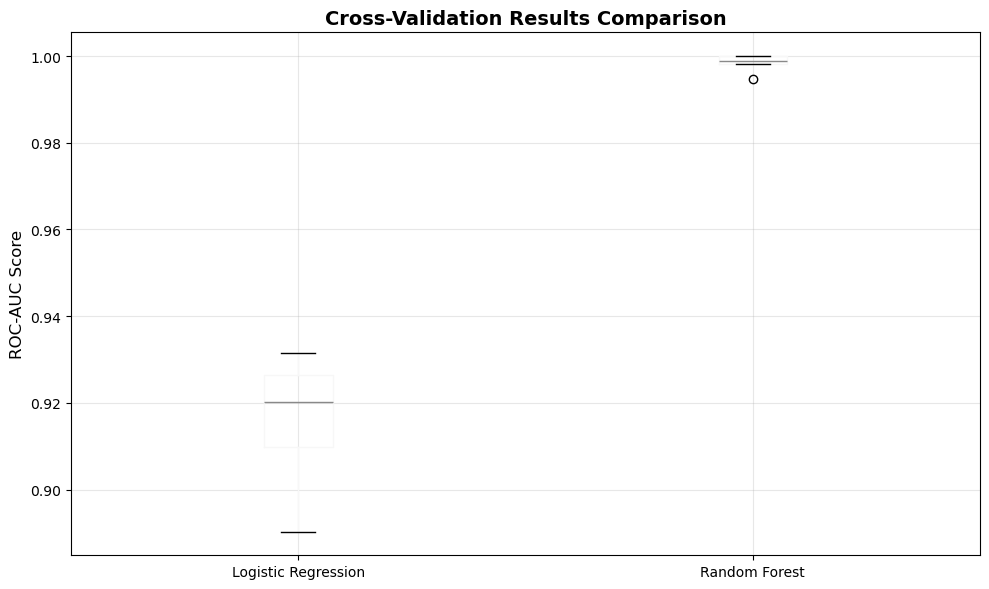

In [ ]:
# Cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Logistic Regression
lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

# Evaluate Random Forest
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print("\n" + "="*50)
print("Cross-Validation Results (ROC-AUC):")
print("="*50)
print(f"\nLogistic Regression:")
print(f"  Mean: {lr_cv_scores.mean():.4f}")
print(f"  Std:  {lr_cv_scores.std():.4f}")
print(f"  Scores: {lr_cv_scores}")

print(f"\nRandom Forest:")
print(f"  Mean: {rf_cv_scores.mean():.4f}")
print(f"  Std:  {rf_cv_scores.std():.4f}")
print(f"  Scores: {rf_cv_scores}")

# Visualize CV results
plt.figure(figsize=(10, 6))
cv_results = pd.DataFrame({
    'Logistic Regression': lr_cv_scores,
    'Random Forest': rf_cv_scores
})
cv_results.boxplot()
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Cross-Validation Results Comparison', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'cv_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Summary and Conclusions
**Task:** Summarize findings and model performance

In [ ]:
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)
print(f"\nDataset: {DATA_PATH.name}")
print(f"Total samples: {len(df)}")
print(f"Features: {len(FEATURES)}")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - Categorical: {len(categorical_features)}")
print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print("\n" + "="*70)
print("BEST MODEL PERFORMANCE")
print("="*70)
best_model_idx = models_comparison['ROC-AUC'].idxmax()
best_model = models_comparison.loc[best_model_idx]
print(f"\nBest Model: {best_model['Model']}")
print(f"  Accuracy:  {best_model['Accuracy']:.4f}")
print(f"  Precision: {best_model['Precision']:.4f}")
print(f"  Recall:    {best_model['Recall']:.4f}")
print(f"  F1-Score:  {best_model['F1-Score']:.4f}")
print(f"  ROC-AUC:   {best_model['ROC-AUC']:.4f}")




PROJECT SUMMARY

Dataset: heart.csv
Total samples: 1025
Features: 13
  - All features are already numerically encoded
  - No missing values in the dataset
  - Preprocessing: StandardScaler only (data already cleaned)

Training samples: 820
Test samples: 205

BEST MODEL PERFORMANCE

Best Model: Random Forest
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000
